# Geração do modelo treinado

In [1]:
# Treino do modelo com hiperparâmetros selecionados
from utils import Experimento

ENV_ID = 'CartPole-v1'
params = {
    'env_id': 'CartPole-v1',
    'n_envs': 1,
    'size': [64, 64],
    'fib_seeds': 1,
    'timesteps': int(1e5),
    'recording': False,
    'device': 'cpu',
    'n_steps': 1024,
    'vf_coef': 1,
    'ent_coef': 1,
}
#todo: alguns ambientes tem condições adicionais, como lidar?
# 2' 12'' usando a GPU
# 0' 42'' usando a CPU
teste = Experimento(params)
teste.treinamento()

# Teste: extração de gradiente

In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import gymnasium
import numpy as np
import torch
# todo: extrair a dimensão do vetor track_gradient diretamente do tamanho da net


env = gymnasium.make("CartPole-v1")
torch.manual_seed(0)
model = PPO("MlpPolicy", env, vf_coef=1, ent_coef= 1 ,n_steps= 1024 ,n_epochs=1, verbose=1, device = torch.device('cpu'))
# 2' 12'' usando a GPU
# 0' 42'' usando a CPU

track_gradient = [[] for _ in range(12)]
track_entropy = []
track_policy = []
track_value = []
track_loss = []
track_hat_KL = []
track_explained_var = []


    

# Treinando o modelo scom o callback personalizado
model.set_random_seed(0)
model.learn(total_timesteps=int(1e5), callback=CustomCallback())
plotagem = np.array(track_gradient)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.1     |
|    ep_rew_mean     | 22.1     |
| time/              |          |
|    fps             | 2760     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 22.2         |
|    ep_rew_mean          | 22.2         |
| time/                   |              |
|    fps                  | 2589         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0001680883 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    en

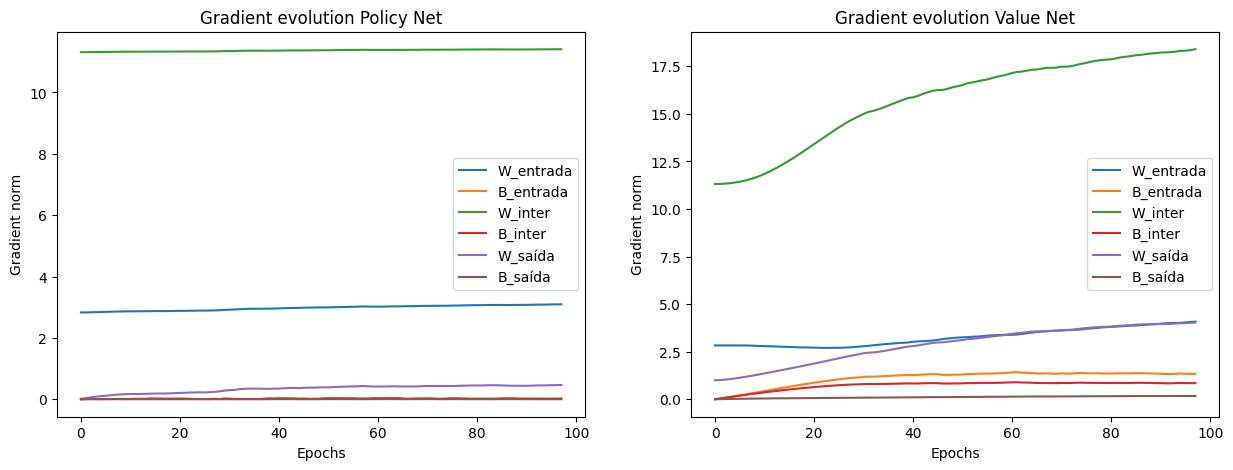

In [7]:
import matplotlib.pyplot as plt
indice_policy = [0,1,2,3,8,9]
indice_value = [4,5,6,7,10,11]

pesos_policy = np.array([track_gradient[i] for i in indice_policy])
pesos_value = np.array([track_gradient[i] for i in indice_value])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

# Plotando os dados no primeiro subplot
ax1.plot(pesos_policy.T)
ax1.set_title('Gradient evolution Policy Net')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Gradient norm')
ax1.legend(['W_entrada', 'B_entrada',
            'W_inter', 'B_inter',
            'W_saída', 'B_saída'
            ])

# Plotando os dados no segundo subplot
ax2.plot(pesos_value.T)
ax2.set_title('Gradient evolution Value Net')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Gradient norm')
ax2.legend(['W_entrada', 'B_entrada',
            'W_inter', 'B_inter',
            'W_saída', 'B_saída'
            ])
plt.show()

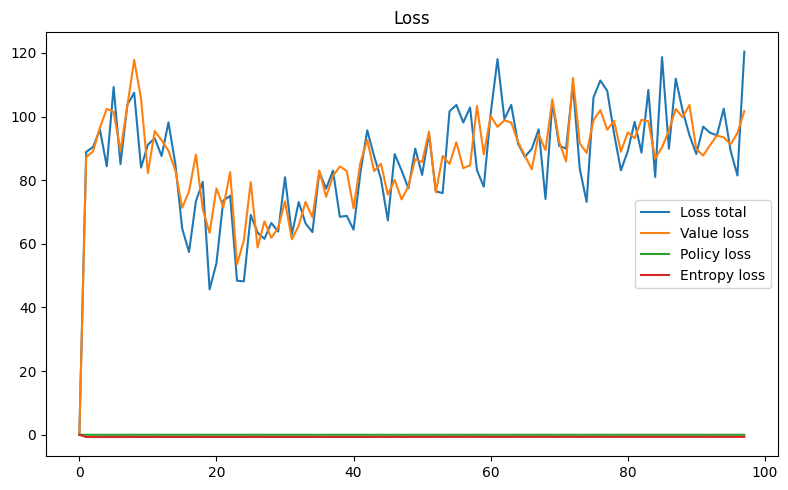

In [8]:
#! Prova de conceito, ainda não terminei de ajustar
plt.figure(figsize=(8, 5))
plt.plot(np.array([track_loss, track_value, track_policy, track_entropy]).T)
plt.legend(['Loss total', 'Value loss', 'Policy loss', 'Entropy loss'])
plt.title('Loss')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Entropy loss')

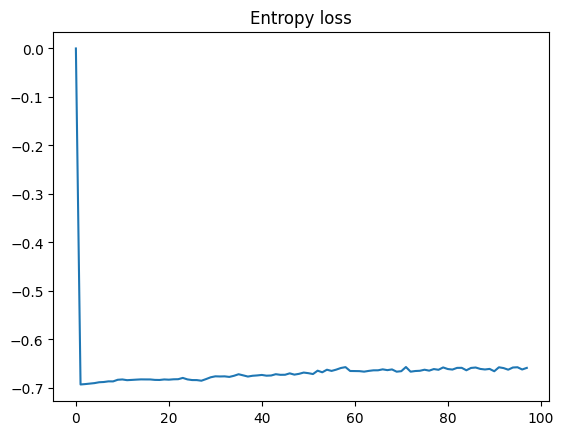

In [9]:
plt.plot(track_entropy)
plt.title('Entropy loss')

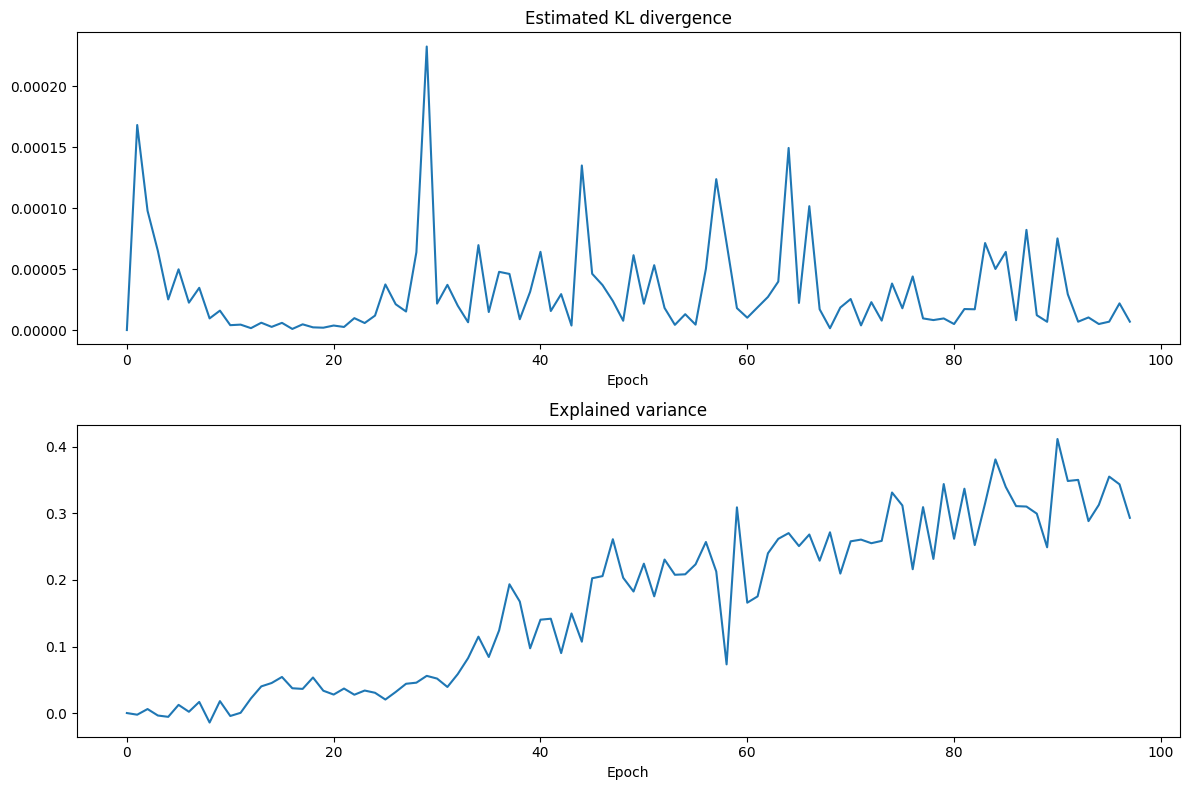

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,8))

ax1.plot(track_hat_KL)
ax1.set_title('Estimated KL divergence')
ax1.set_xlabel('Epoch')


ax2.plot(track_explained_var)
ax2.set_title('Explained variance')
ax2.set_xlabel('Epoch')
plt.tight_layout()
plt.show()

# Extração de informações

In [11]:
teste.visualizar_modelo_ppo()

NameError: name 'teste' is not defined

In [11]:
# Visualização
import gymnasium
from stable_baselines3.ppo import PPO
import keyboard
import pandas as pd
import numpy as np

env = gymnasium.make('CartPole-v1')
modelo = teste.model

df = pd.DataFrame(columns=['Seed', 'Iteração', 'Posição', 'Velocidade', 'Ângulo', 'Velocidade Angular', 'Distribuição', 'Entropia'])


modelo.set_random_seed(0)   #* Reprodutibilidade 
seeds = utils.fib(4)        #* Reprodutibilidade 
vec = [[] for _ in range(len(seeds))] 


for i, seed in enumerate(seeds):
    obs = env.reset(seed=seed)[0]   #* Reprodutibilidade 
    done = False
    while not done:
        tensor_obs = modelo.policy.obs_to_tensor(obs)[0]
        action1 = modelo.policy.predict_values(tensor_obs)
        action2 = modelo.policy.get_distribution(tensor_obs)
        
        action, _ = modelo.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        vec[i].append(obs)
        done = terminated or truncated
    env.close()

In [12]:
value = np.zeros(1000)
dist = np.zeros((1000,2))
pos = np.linspace(-2.4, 2.4, 1000) #hã?
for i, j in enumerate(pos):
    tensor_obs = modelo.policy.obs_to_tensor(np.array([j, 0,0,0]))[0]
    value[i] = modelo.policy.predict_values(tensor_obs)[0,0].detach().numpy()
    dist[i] = modelo.policy.get_distribution(tensor_obs).distribution.probs[0].detach().numpy()

In [ ]:
plt.plot(pos, dist)
plt.title('Ação')
plt.legend(['Esquerda', 'Direita'])
plt.show()

In [ ]:
# Tentativa de ver as trajetórias ao longo do tempo

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
observation = np.array(vec)

plotagem = []
new = RobustScaler()
for i in range(observation.shape[0]):
    adjusted_data = new.fit_transform(observation[i])
    temp = []
    for j in range(adjusted_data.shape[0]):
        temp.extend([np.sum(adjusted_data[j])/4])
    plotagem.append(temp)
plt.plot(np.array(plotagem).T)
plt.legend([f'Seed {i}' for i in seeds])
plt.show()

In [ ]:
plt.plot(observation[0])
plt.title('Entropy')
plt.show()

# Rota value: Confiabilidade

In [15]:
# Visualização
import gymnasium
import keyboard
import matplotlib.pyplot as plt
import numpy as np

env = gymnasium.make('CartPole-v1')
modelo = teste.model

seeds = utils.fib(2)
position = np.zeros((len(seeds), 500, 4))
modelo.set_random_seed(0)
for i, seed in enumerate(seeds):
    j = 0
    obs = env.reset(seed=seed)[0]
    done = False
    while not done:
        action, _ = modelo.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        position[i,j] = obs
        done = terminated or truncated
        j += 1
        if keyboard.is_pressed('esc'):
            break
    env.close()

In [ ]:
# o plano era fazer a evolução dos parâmetros ao longo do tempo, mas n deu mt certo n
plt.plot(position[0,:,:])

In [ ]:
clear_position = np.array(position[:,:,0]).reshape(-1)
counts, bins = np.histogram(clear_position, bins=20, density=False)

# for i in position:
#     plt.plot(i, np.arange(1,501))

plt.hist(clear_position, bins.size)
plt.xlabel('Posição')
plt.ylabel('Contagem')
plt.title('Histograma da posição do carrinho')
plt.show()

## Usando LQR

In [ ]:
# code from https://github.com/JoKoum/reinforcement-learning-vs-control-theory/blob/master/cartpole_control_theory.py

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import gymnasium

class Controller:
    '''Implements a feedback controller'''
    def __init__(self, environment):
        # gravity
        self.g = 10
        # pole length
        self.lp = environment.env.get_wrapper_attr('length')
        # pole mass
        self.mp = environment.env.get_wrapper_attr('masspole')
        # cart mass
        self.mk = environment.env.get_wrapper_attr('masscart')
        # total mass
        self.mt = environment.env.get_wrapper_attr('total_mass')
        
    def state_controller(self):
        # state matrix
        a = self.g/(self.lp*(4.0/3 - self.mp/(self.mp+self.mk)))
        A = np.array([[0, 1, 0, 0],
              [0, 0, a, 0],
              [0, 0, 0, 1],
              [0, 0, a, 0]])
              
        # input matrix
        b = -1/(self.lp*(4.0/3 - self.mp/(self.mp+self.mk)))
        B = np.array([[0], [1/self.mt], [0], [b]])
        
        # choose R (weight for input)
        R = np.eye(1, dtype=int)
        # choose Q (weight for state)
        Q = 5*np.eye(4, dtype=int)
        
        # solve ricatti equation
        P = linalg.solve_continuous_are(A, B, Q, R)     #! Tem algo aqui que crasha o kernel
        
        # calculate optimal controller gain
        K = np.dot(np.linalg.inv(R), np.dot(B.T, P))

        return K
        
    def apply_state_controller(self, x):
        K = self.state_controller()
        # feedback controller
        u = -np.dot(K, x)[0]   # u = -Kx
        if u > 0:
            return 1, u     # if force_dem > 0 -> move cart right
        else:
            return 0, u     # if force_dem <= 0 -> move cart left

def run_experiment(rounds = 1000):
    '''Perform an experiment. Control the cart-pole system'''
    # get environment
    env = gymnasium.make('CartPole-v1', render_mode = 'human')
    obs = env.reset(seed= 0)[0]

    controller = Controller(env)

    position_list = []
    velocity_list = []
    angle_list = []
    angular_velocity_list = []
    steps = []
    flag = True
    
    for i in range(rounds):        
        # get force direction (action) and force value (force)
        action, force = controller.apply_state_controller(obs)
        
        #absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
        # abs_force = abs(float(np.clip(force, -10, 10)))
        
        # change magnitute of the applied force in CartPole
        # env.env.force_mag = abs_force
        
        # apply action
        obs, reward, terminated, truncated, info = env.step(action)

        
        # store state, time
        position_list.append(obs[0])
        velocity_list.append(obs[1])
        angle_list.append(obs[2])
        angular_velocity_list.append(obs[3])
        steps.append(i)
        
        done = terminated or truncated

        if done and flag:
            print(f'Threshold reached after {i+1} iterations.')
            flag = False
        if i > 499:
            break
        
    env.close()
    
    fig, ax = plt.subplots(2,2, figsize=(15,8))
    ax[0][0].plot(steps, position_list)
    ax[0][0].set_xlabel('Time steps')
    ax[0][0].set_ylabel('Position (m)')
    ax[0][0].grid()
    
    ax[0][1].plot(steps, velocity_list, 'r')
    ax[0][1].set_xlabel('Time steps')
    ax[0][1].set_ylabel('Velocity (m/s)')
    ax[0][1].grid()
    
    ax[1][0].plot(steps, angle_list, 'g')
    ax[1][0].set_xlabel('Time steps')
    ax[1][0].set_ylabel('Angle (rad)')
    ax[1][0].grid()
    
    ax[1][1].plot(steps, angular_velocity_list, 'y')
    ax[1][1].set_xlabel('Time steps')
    ax[1][1].set_ylabel('Angular Velocity (rad/s)')
    ax[1][1].grid()
    
    plt.suptitle('Observations per step')
    plt.tight_layout()
    plt.show()
run_experiment()